In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from deap import base, creator, tools, algorithms
import warnings
warnings.simplefilter("ignore")  # Ignores all warnings

In [4]:
# Fetch BTC-USD data from Yahoo Finance
df = yf.download('BTC-USD', start='2020-01-01', end='2024-11-20')

# Define the mean reversion strategy
def mean_reversion_strategy(df, ema_period, threshold):
    if ema_period < 1:
        return -np.inf  # Return a very low value if ema_period is invalid
    
    df['EMA'] = df['Close'].ewm(span=ema_period).mean()
    df['distance'] = df['Close'] - df['EMA']
    
    df['position'] = np.where(df['distance'] > threshold, -1, np.nan)
    df['position'] = np.where(-df['distance'] > threshold, 1, df['position'])
    df['position'] = np.where(df['distance'] * df['distance'].shift(1) < 0, 0, df['position'])
    df['position'] = df['position'].ffill().fillna(0)
    
    df['strategy_return'] = df['position'].shift(1) * df['Close'].pct_change()
    df['cumulative_return'] = (df['strategy_return'] + 1).cumprod() - 1
    
    return df['cumulative_return'].iloc[-1]

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Genetic Algorithm Optimization
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", np.random.randint, 1, 90)  # Ensure EMA period is at least 1
toolbox.register("attr_float", np.random.uniform, 1000, 20000)  # Threshold

toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_int, toolbox.attr_float), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    ema_period, threshold = individual
    return mean_reversion_strategy(df.copy(), ema_period, threshold),

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    population = toolbox.population(n=50)
    ngen, cxpb, mutpb = 20, 0.5, 0.2
    
    result, log = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, verbose=False)
    
    best_individual = tools.selBest(population, k=1)[0]
    return best_individual

best_individual = main()
best_ema_period, best_threshold = best_individual

print(f"Best EMA period: {best_ema_period}")
print(f"Best Threshold: {best_threshold}")


Best EMA period: 28.66382853887139
Best Threshold: 12234.051524301985


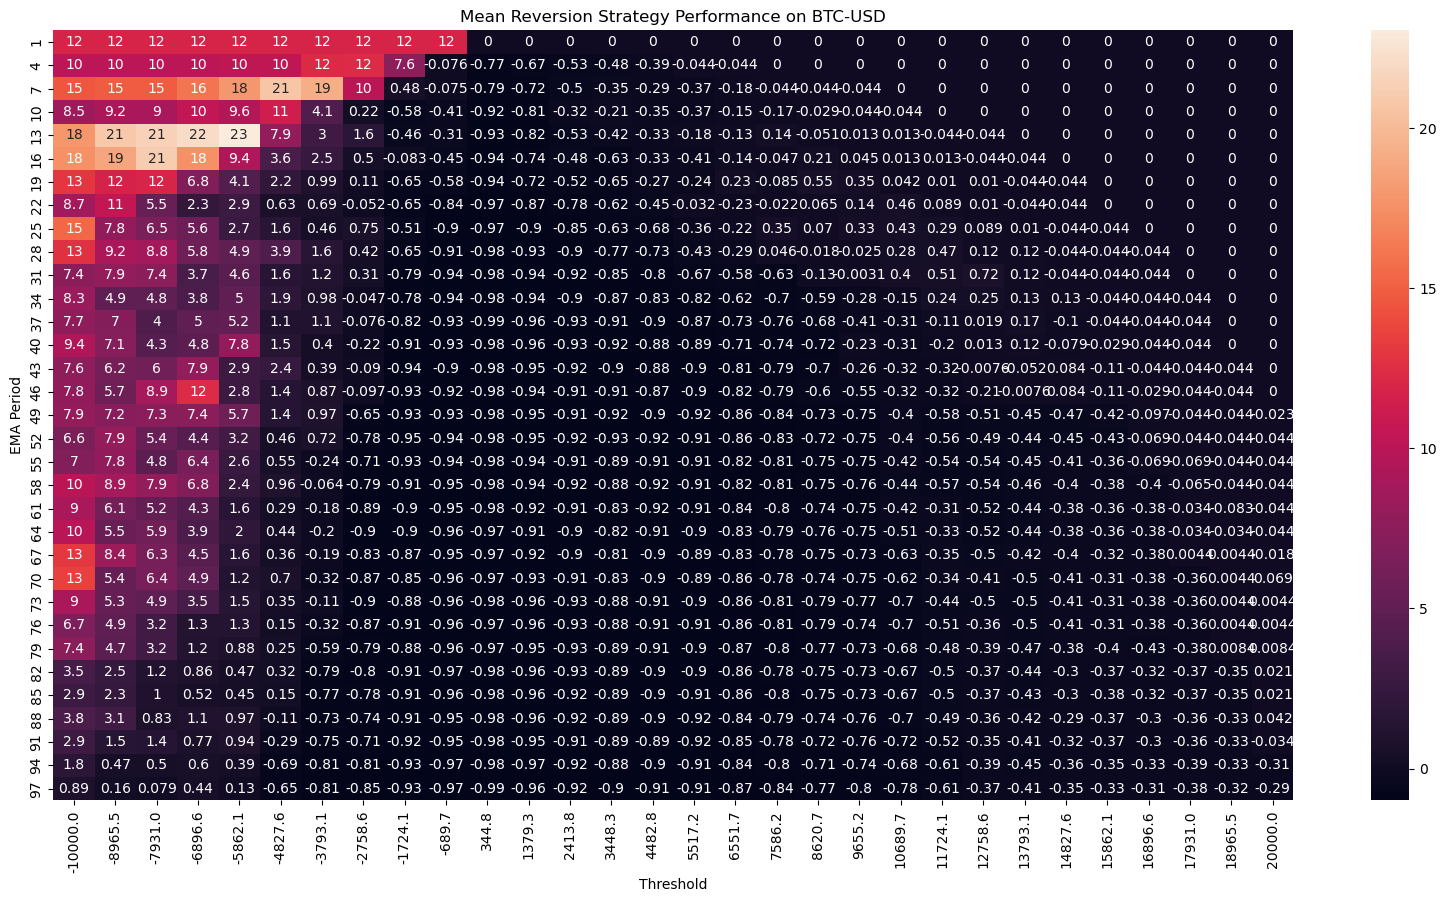

In [6]:
# Define ranges for EMA periods and thresholds
ema_periods = range(1, 100, 3)  # Ensure EMA period starts from 1
thresholds = np.linspace(-10000, 20000, 30)

# Initialize a results matrix
results = np.zeros((len(ema_periods), len(thresholds)))

# Evaluate the strategy for each combination of EMA period and threshold
for i, ema_period in enumerate(ema_periods):
    for j, threshold in enumerate(thresholds):
        results[i, j] = mean_reversion_strategy(df.copy(), ema_period, threshold)

# Plot the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(results, annot=True, xticklabels=thresholds.round(1), yticklabels=ema_periods)
plt.xlabel('Threshold')
plt.ylabel('EMA Period')
plt.title('Mean Reversion Strategy Performance on BTC-USD')
plt.show();

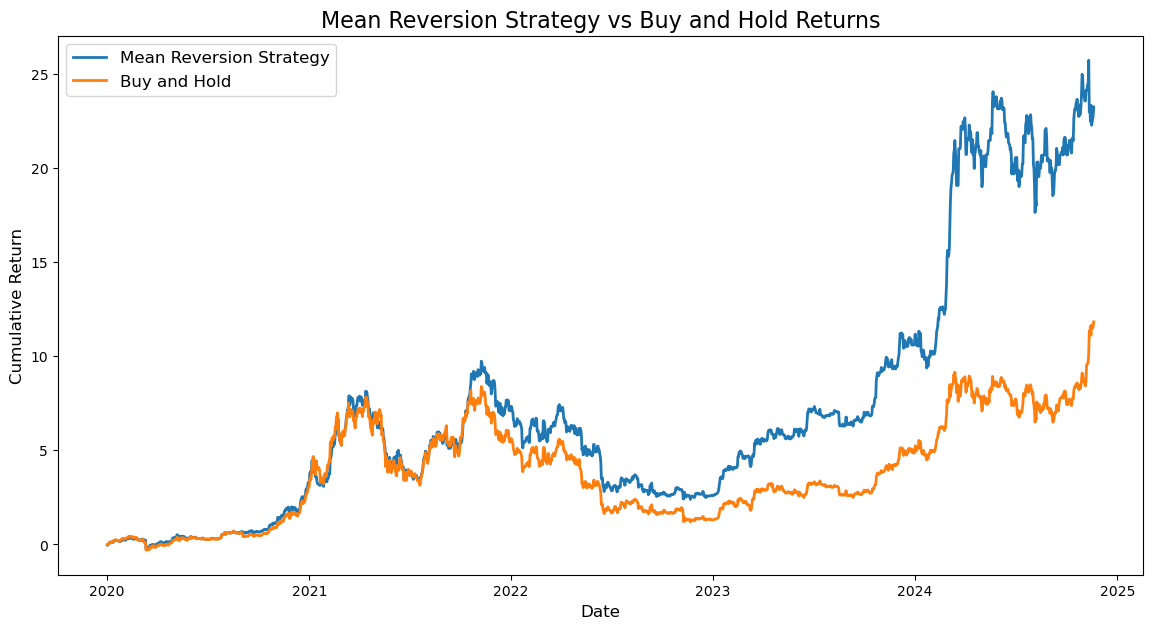

In [9]:
def mean_reversion_strategy(df, ema_period, threshold):
    df['EMA'] = df['Close'].ewm(span=ema_period).mean()
    df['distance'] = df['Close'] - df['EMA']
    
    df['position'] = np.where(df['distance'] > threshold, -1, np.nan)
    df['position'] = np.where(-df['distance'] > threshold, 1, df['position'])
    df['position'] = np.where(df['distance'] * df['distance'].shift(1) < 0, 0, df['position'])
    df['position'] = df['position'].ffill().fillna(0)
    
    df['strategy_return'] = df['position'].shift(1) * df['Close'].pct_change()
    df['strategy_cumulative'] = (df['strategy_return'] + 1).cumprod() - 1
    
    df['buy_and_hold'] = (df['Close'].pct_change() + 1).cumprod() - 1
    
    return df[['strategy_cumulative', 'buy_and_hold']]

# Apply the strategy using optimized parameters
best_ema_period =  13
best_threshold = -6000  # Example threshold

returns = mean_reversion_strategy(df.copy(), best_ema_period, best_threshold)

# Plot the strategy return vs buy-and-hold return
plt.figure(figsize=(14, 7))
plt.plot(df.index, returns['strategy_cumulative'], label='Mean Reversion Strategy', linewidth=2)
plt.plot(df.index, returns['buy_and_hold'], label='Buy and Hold', linewidth=2)
plt.title('Mean Reversion Strategy vs Buy and Hold Returns', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(fontsize=12)
plt.show()